In [25]:
import openl3
import librosa
import soundfile as sf
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


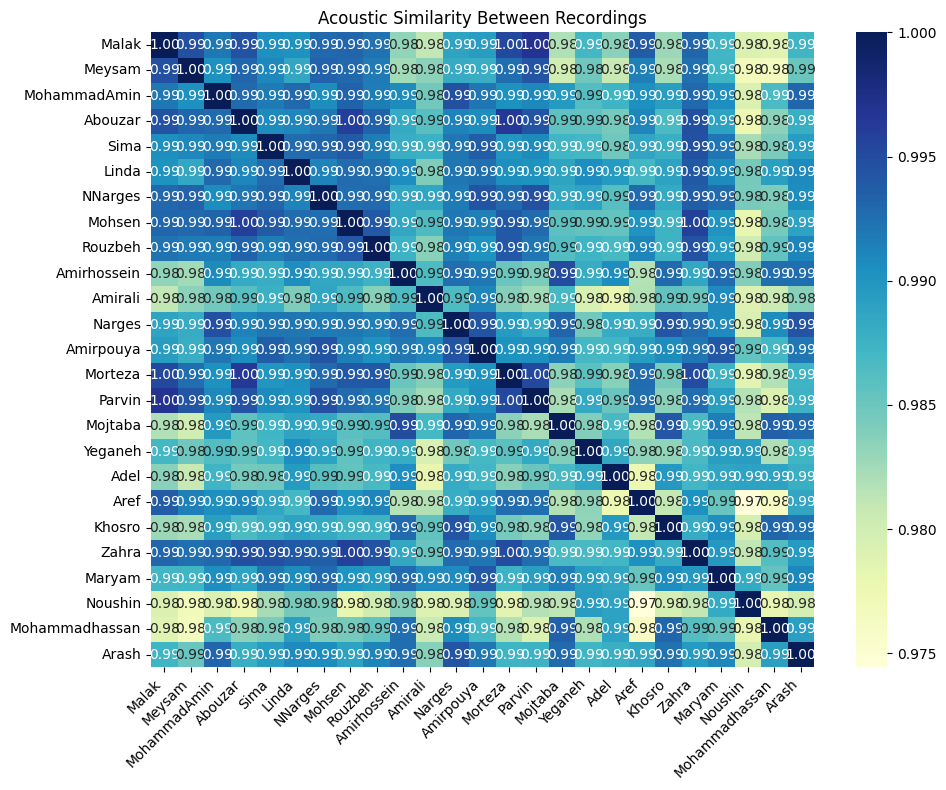

In [19]:
def load_audio(path, target_sr=16000):
    audio, _ = librosa.load(path, sr=target_sr, mono=True)
    return audio, target_sr

def extract_openl3_embedding(audio, sr):
    emb, _ = openl3.get_audio_embedding(audio, sr, content_type="env", embedding_size=512)
    return np.mean(emb, axis=0)

# --- Directory with .wav files ---
folder = "data/Recordings_Persian/Preprocessed/"
files = [f for f in os.listdir(folder) if f.endswith(".wav")]

# --- Extract embeddings ---
embeddings = {}
for f in files:
    path = os.path.join(folder, f)
    audio, sr = load_audio(path)
    embeddings[f] = extract_openl3_embedding(audio, sr)

# --- Create similarity matrix ---
n = len(files)
sim_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        emb_i = embeddings[files[i]]
        emb_j = embeddings[files[j]]
        sim_matrix[i, j] = 1 - cosine(emb_i, emb_j)

# --- Plot heatmap ---
plt.figure(figsize=(10, 8))
labels = [f.replace("Kikeriki_Persian_", "").replace(".wav", "") for f in files]
sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Acoustic Similarity Between Recordings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


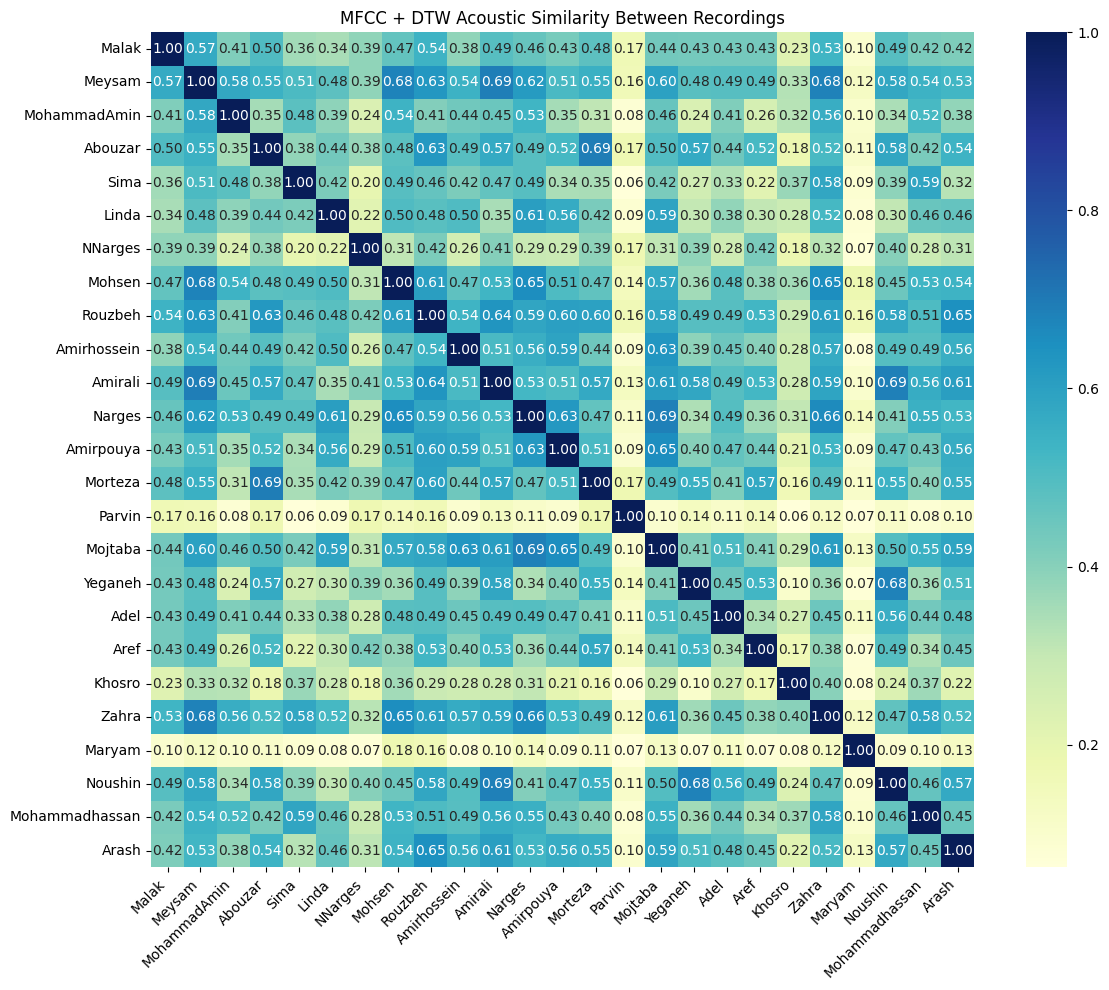

In [27]:
# === SETTINGS ===
folder = "data/Recordings_Persian/Preprocessed/"
files = [f for f in os.listdir(folder) if f.endswith(".wav")]

# === EXTRACT MFCCs ===
mfccs = {}
for f in files:
    path = os.path.join(folder, f)
    y, sr = librosa.load(path, sr=16000, mono=True)
    y, _ = librosa.effects.trim(y)  # trim silence
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T  # shape: (frames, 13)
    mfccs[f] = mfcc

# === COMPUTE PAIRWISE DTW DISTANCES ===
n = len(files)
dist_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        d, _ = fastdtw(mfccs[files[i]], mfccs[files[j]], dist=euclidean)
        dist_matrix[i, j] = d

# === CONVERT DISTANCE TO SIMILARITY (OPTIONAL NORMALIZATION) ===
sim_matrix = np.exp(-dist_matrix / np.mean(dist_matrix))

# === LABELS: Strip to names only ===
labels = [f.replace("Kikeriki_Persian_", "").replace(".wav", "") for f in files]

# === PLOT HEATMAP ===
plt.figure(figsize=(12, 10))
sns.heatmap(sim_matrix, xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("MFCC + DTW Acoustic Similarity Between Recordings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
